# Data Descriptions

In this competition, you'll classify 60-second sequences of sensor data, indicating whether a subject was in either of two activity states for the duration of the sequence

In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, precision_score, f1_score
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_curve, roc_auc_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_validate
from sklearn.datasets import make_classification
from sklearn.metrics import plot_confusion_matrix


print("Version Pandas", pd.__version__)
print("Version Matplotlib", matplotlib.__version__)
print("Version Numpy", np.__version__)
print("Version Seaborn", sns.__version__)
print("Version Sklearn",sklearn.__version__)

Version Pandas 1.3.5
Version Matplotlib 3.5.1
Version Numpy 1.20.3
Version Seaborn 0.11.2
Version Sklearn 1.0.1


# Files and Field Descriptions
- train.csv - the training set, comprising ~26,000 60-second recordings of thirteen biological sensors for almost one thousand experimental participants
    + sequence - a unique id for each sequence
    + subject - a unique id for the subject in the experiment
    + step - time step of the recording, in one second intervals
    + sensor_00 - sensor_12 - the value for each of the thirteen sensors at that time step
- train_labels.csv - the class label for each sequence.
    + sequence - the unique id for each sequence.
    + state - the state associated to each sequence. This is the target which you are trying to predict.
- test.csv - the test set. For each of the ~12,000 sequences, you should predict a value for that sequence's state.
- sample_submission.csv - a sample submission file in the correct format.

In [2]:
train = pd.read_csv("../input/tabular-playground-series-apr-2022/train.csv")
target = pd.read_csv("../input/tabular-playground-series-apr-2022/train_labels.csv")
test = pd.read_csv("../input/tabular-playground-series-apr-2022/test.csv")
submission = pd.read_csv("../input/tabular-playground-series-apr-2022/sample_submission.csv")

train1 = pd.read_csv('../input/tabular-playground-series-apr-2022/train.csv',index_col=['sequence', 'subject', 'step'])

/opt/conda/lib/python3.7/site-packages/numpy/lib/arraysetops.py:583: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


## TRAIN DATA SET 

In [3]:
train.tail(10)

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
1558070,25967,327,50,0.299073,0.485294,-1.332820,0.543363,-0.042965,-0.119671,-0.249545,1.054962,-1.1,-0.082370,-0.048687,0.738683,0.909207
1558071,25967,327,51,-0.410355,0.322479,-1.332820,-1.417699,-0.883976,-0.610322,-0.375228,-1.291603,0.5,0.283960,-0.731583,0.007202,-0.830776
1558072,25967,327,52,-0.076507,0.339286,-1.476153,2.101770,0.919306,-0.382199,1.729508,0.770992,0.0,-0.558526,0.505781,0.614198,-1.007246
1558073,25967,327,53,0.915765,-0.719538,-1.666153,0.400885,0.359774,-0.371728,-0.804189,0.978626,0.2,0.646676,0.669271,0.229424,1.064365
1558074,25967,327,54,-0.551777,0.897059,-1.666153,-2.052212,-0.314799,-0.197457,0.032787,-1.640458,-1.2,-0.647399,-0.596996,-0.728395,0.639812
1558075,25967,327,55,-0.282844,-1.217437,-1.666153,0.586726,-0.930698,-0.451010,-0.651184,0.368702,0.4,0.008671,-0.723536,-0.353909,-0.914749
1558076,25967,327,56,0.130603,0.349790,-1.666153,-0.324779,0.775324,-0.332835,0.099271,0.122137,-0.2,0.644509,0.691407,-0.613169,-0.515772
1558077,25967,327,57,-0.579598,0.429622,-1.666153,0.319469,0.308861,0.282723,-0.512750,0.012214,-1.6,-0.424133,0.716855,1.628601,0.928389
1558078,25967,327,58,1.278980,1.711134,-1.522820,0.802655,-0.460541,-0.055348,2.405282,0.043511,1.9,0.283960,-0.914914,0.364198,0.211424
1558079,25967,327,59,-1.136012,-3.702731,-1.332820,-0.766372,-0.430027,-0.091997,-2.512750,-0.022901,-1.1,-0.653902,-0.418516,-1.453704,-1.561381


rows : 1558080,  columns : 16

In [4]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1558080 entries, 0 to 1558079
Data columns (total 16 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   sequence   1558080 non-null  int64  
 1   subject    1558080 non-null  int64  
 2   step       1558080 non-null  int64  
 3   sensor_00  1558080 non-null  float64
 4   sensor_01  1558080 non-null  float64
 5   sensor_02  1558080 non-null  float64
 6   sensor_03  1558080 non-null  float64
 7   sensor_04  1558080 non-null  float64
 8   sensor_05  1558080 non-null  float64
 9   sensor_06  1558080 non-null  float64
 10  sensor_07  1558080 non-null  float64
 11  sensor_08  1558080 non-null  float64
 12  sensor_09  1558080 non-null  float64
 13  sensor_10  1558080 non-null  float64
 14  sensor_11  1558080 non-null  float64
 15  sensor_12  1558080 non-null  float64
dtypes: float64(13), int64(3)
memory usage: 190.2 MB


- 결측치 없음.

In [5]:
print('Train Data total missing values :', sum(train.isna().sum()))
print('')
print('Train Data missing values :')
print(train.isna().sum().sort_values(ascending = False))

Train Data total missing values : 0

Train Data missing values :
sequence     0
subject      0
step         0
sensor_00    0
sensor_01    0
sensor_02    0
sensor_03    0
sensor_04    0
sensor_05    0
sensor_06    0
sensor_07    0
sensor_08    0
sensor_09    0
sensor_10    0
sensor_11    0
sensor_12    0
dtype: int64


In [6]:
train.nunique()

sequence      25968
subject         672
step             60
sensor_00     25792
sensor_01     28326
sensor_02      4771
sensor_03     26976
sensor_04    387971
sensor_05     22839
sensor_06     25078
sensor_07     28147
sensor_08      1924
sensor_09     30127
sensor_10    268478
sensor_11     28932
sensor_12    303949
dtype: int64

- train 데이터의 시퀀스 한개에 state 0 or 1 의 값을 갖는다.
- train 과 target을 이용하여 test의 state 값의 분포를 찾는 문제.

## TARGET DATA SET

In [7]:
print(target.tail())

target.nunique()

       sequence  state
25963     25963      1
25964     25964      0
25965     25965      1
25966     25966      1
25967     25967      0


sequence    25968
state           2
dtype: int64

## TEST DATA SET

In [8]:
test.head()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
0,25968,684,0,2.427357,19.639706,1.0,-1.466372,-1.289973,-4.207928,2.486339,-2.493893,8.0,-1.123555,-1.673048,10.980453,0.419011
1,25968,684,1,-4.950541,-21.747899,1.0,0.983186,-0.569053,1.845924,-3.887978,1.727481,-2.9,0.395231,-0.882233,-1.871399,-0.008525
2,25968,684,2,1.136012,-10.756303,1.0,1.016814,0.964157,2.454749,0.312386,1.154198,-5.6,1.114162,1.525273,-11.584362,0.139812
3,25968,684,3,0.806028,6.504202,1.0,-0.179646,0.969221,-1.035153,-0.457195,0.254962,-2.7,-0.588873,0.608761,-4.241770,-0.462916
4,25968,684,4,1.288253,5.552521,1.0,-0.493805,-1.036124,-1.126402,2.008197,-0.730534,0.0,0.899566,-1.259615,-0.472222,-0.121483


- 훈련 데이터와 테스트 데이터의 시퀀스아이디 하나당 60초동안 센서값을 보여주기 때문에 시퀀스 아이디 하나로 그룹화 하여 아이디들의 데이터를 추출하는것이 좋아 보임.

# EDA

In [9]:
print('Frequency of each target classes:')
target['state'].value_counts()

Frequency of each target classes:


1    13014
0    12954
Name: state, dtype: int64

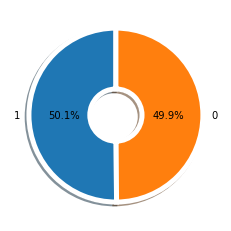

In [10]:
# Frequency of each target classes

import matplotlib.pyplot as plt

ratio = target['state'].value_counts()
labels = ['1','0']
wedgeprops = {'width': 0.7, 'edgecolor': 'w', 'linewidth': 5}


plt.pie(ratio, labels=labels, startangle=90, autopct='%.1f%%', shadow=True, wedgeprops=wedgeprops)
plt.show()

In [11]:
train.corr()

,sequence,subject,step,sensor_00,sensor_01,sensor_02,sensor_03,sensor_04,sensor_05,sensor_06,sensor_07,sensor_08,sensor_09,sensor_10,sensor_11,sensor_12
sequence,1.000000e+00,-3.247774e-03,5.821928e-15,-0.000085,-0.000101,0.005470,0.000315,0.000416,0.000265,-0.000060,0.000188,0.000377,-0.000251,-0.000186,1.706946e-04,-0.000037
subject,-3.247774e-03,1.000000e+00,-1.040897e-16,0.000170,-0.000031,0.007330,-0.000036,-0.000607,-0.000150,-0.000132,0.000092,-0.000269,0.000080,-0.000852,1.091758e-04,0.000469
step,5.821928e-15,-1.040897e-16,1.000000e+00,-0.000246,0.000037,0.000065,0.000564,-0.000047,-0.000072,-0.000086,0.000185,0.000203,-0.000091,-0.000466,5.444838e-07,0.000249
sensor_00,-8.500061e-05,1.700495e-04,-2.458090e-04,1.000000,0.270416,0.000134,-0.045438,-0.001280,0.001453,0.531812,0.049807,-0.004507,0.478972,-0.000233,-8.952496e-02,-0.000120
sensor_01,-1.009615e-04,-3.086204e-05,3.712678e-05,0.270416,1.000000,0.000253,0.007056,0.004169,-0.004363,0.328691,-0.055740,-0.005967,0.222082,0.000088,2.450832e-01,-0.001769
sensor_02,5.470164e-03,7.329859e-03,6.542708e-05,0.000134,0.000253,1.000000,-0.000646,0.000290,0.001385,0.000143,-0.000402,-0.000403,0.000202,0.003469,-8.829585e-05,-0.000343
sensor_03,3.152981e-04,-3.570893e-05,5.639744e-04,-0.045438,0.007056,-0.000646,1.000000,-0.001226,0.002956,0.031617,0.565541,0.012267,-0.023650,-0.005500,5.015281e-01,-0.000658
sensor_04,4.156163e-04,-6.074459e-04,-4.712730e-05,-0.001280,0.004169,0.000290,-0.001226,1.000000,0.001469,-0.001009,-0.002383,-0.000150,0.002782,0.227802,-1.558559e-03,-0.016335
sensor_05,2.654310e-04,-1.501425e-04,-7.177237e-05,0.001453,-0.004363,0.001385,0.002956,0.001469,1.000000,-0.002843,0.004495,0.005055,0.001418,0.001771,-2.790758e-04,0.000817
sensor_06,-5.975779e-05,-1.316732e-04,-8.559685e-05,0.531812,0.328691,0.000143,0.031617,-0.001009,-0.002843,1.000000,-0.005468,0.003308,0.407189,0.000640,-1.023150e-02,-0.000749


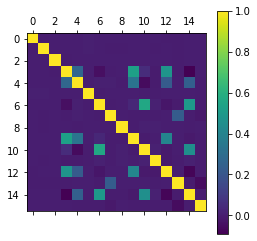

In [12]:
# 훈련 데이터의 각 컬럼과의 상관관계
import matplotlib.pyplot as plt
import numpy as np

arr = train.corr()

plt.matshow(arr)
plt.colorbar()
plt.show()

In [13]:
# train 데이터를 0~59 초씩 묶은 리스트
# a_split = np.array_split(train, 25968, axis=0)
                         
# print(a_split[1:2]) # 리스트이기 때문에 슬라이싱을 사용.

In [14]:
# get the name of all sensor columns
sensor_columns = [col for col in train.columns
                  if 'sensor' in col.split('_')]

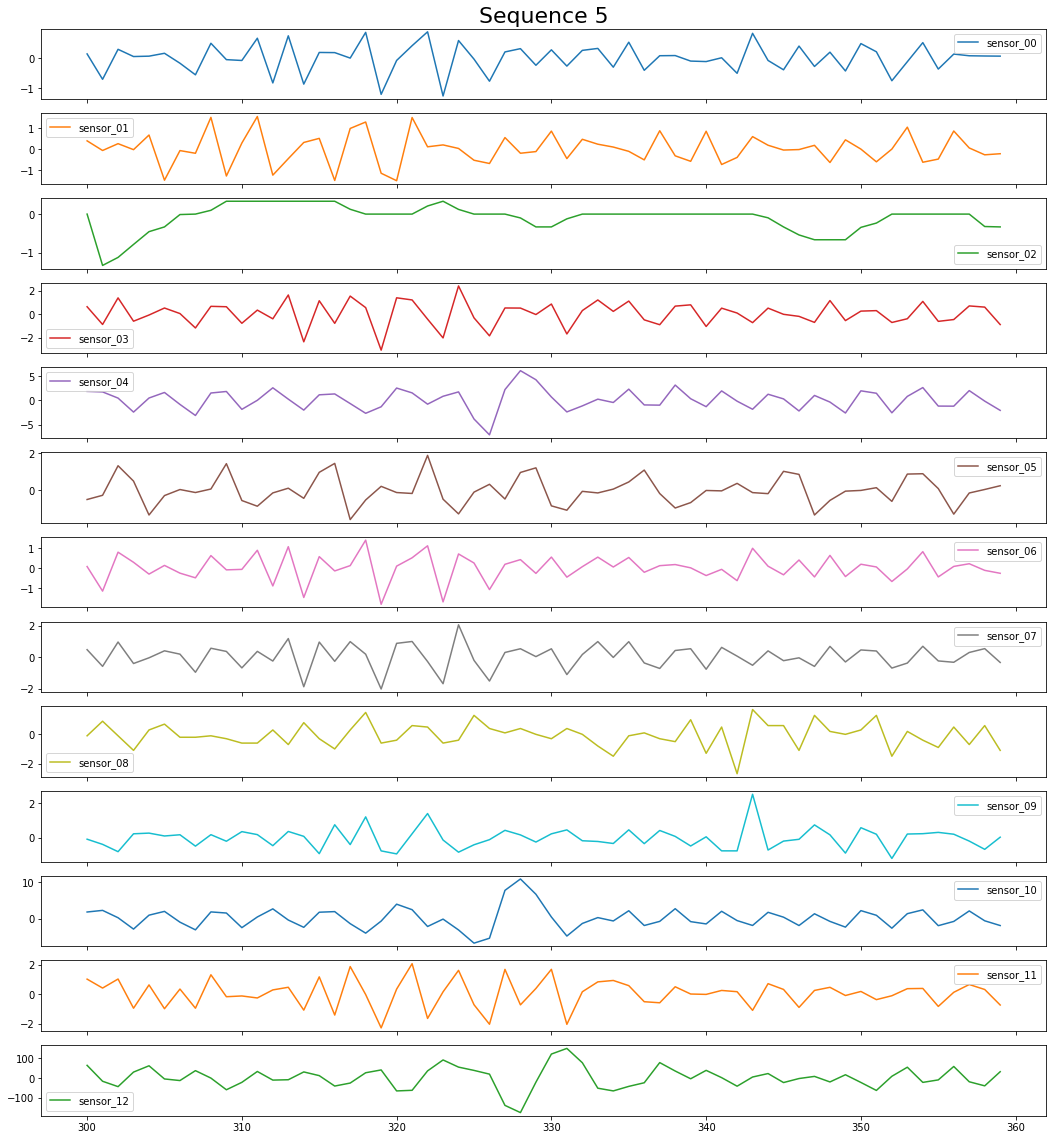

In [15]:
# 시퀀스별로 60초동안의 센서의 값을 보여주는 그래프
def plot_sequence(sequence: int) -> None:
    mask = train.sequence == sequence
    ax = train[mask][sensor_columns].plot(subplots=True,
                                             sharex=True,
                                             figsize=(18, 20))
    ax[0].set_title(f'Sequence {sequence}', size=22)
    plt.show()

plot_sequence(5) # 시퀀스에 있는 센서 0 ~ 12 개의 60초동안 그래프

In [16]:
# 센서의 통계값 
print(train1.describe())

          sensor_00     sensor_01     sensor_02     sensor_03     sensor_04  \
count  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06   
mean   4.365526e-04 -1.034982e-03 -2.178045e-01 -2.156555e-03 -1.828903e-03   
std    2.658684e+00  4.404200e+00  2.298002e+00  3.934184e+00  1.683685e+00   
min   -3.750634e+02 -4.345977e+02 -3.165948e+01 -4.083761e+02 -2.362601e+01   
25%   -5.000000e-01 -4.831933e-01 -6.461531e-01 -4.929204e-01 -4.729928e-01   
50%   -3.091190e-03  3.151261e-03  0.000000e+00  0.000000e+00 -1.589577e-03   
75%    4.845440e-01  4.926471e-01  3.338469e-01  4.893805e-01  4.701565e-01   
max    3.358246e+02  4.495914e+02  1.666667e+00  4.366504e+02  2.487286e+01   

          sensor_05     sensor_06     sensor_07     sensor_08     sensor_09  \
count  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06  1.558080e+06   
mean  -1.651785e-03 -4.122917e-04 -2.620665e-05 -1.298393e-04  1.365584e-03   
std    1.590818e+00  3.345143e+00  3.243428e+00  4.

# Data Preprocessing

In [17]:

# extracting statistical information from the train data, credit to @xinyangkabuda
from scipy.stats.mstats import gmean
sensor = ['00','01','02','03','04','05','06','07','08','09','10','11','12']
for i in sensor:
    train[f'sensor_{i}_step_mean'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('mean')
    train[f'sensor_{i}_step_median'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('median')
    train[f'sensor_{i}_step_std'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('std')
    train[f'sensor_{i}_step_min'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('min')
    train[f'sensor_{i}_step_max'] = train.groupby(['sequence','subject'])[f'sensor_{i}'].transform('max')
    
    test[f'sensor_{i}_step_mean'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('mean')
    test[f'sensor_{i}_step_median'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('median')
    test[f'sensor_{i}_step_std'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('std')
    test[f'sensor_{i}_step_min'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('min')
    test[f'sensor_{i}_step_max'] = test.groupby(['sequence','subject'])[f'sensor_{i}'].transform('max')


In [18]:
train_total = pd.merge(train, target, on="sequence")
# print(train_total.shape)
print(train_total.head())

   sequence  subject  step  sensor_00  sensor_01  sensor_02  sensor_03  \
0         0       47     0  -0.196291   0.112395        1.0   0.329204   
1         0       47     1  -0.447450   0.134454        1.0  -0.658407   
2         0       47     2   0.326893  -0.694328        1.0   0.330088   
3         0       47     3   0.523184   0.751050        1.0   0.976991   
4         0       47     4   0.272025   1.074580        1.0  -0.136283   

   sensor_04  sensor_05  sensor_06  ...  sensor_11_step_median  \
0  -1.004660  -0.131638  -0.127505  ...               0.193416   
1   0.162495   0.340314  -0.209472  ...               0.193416   
2   0.473678   1.280479  -0.094718  ...               0.193416   
3  -0.563287  -0.720269   0.793260  ...               0.193416   
4   0.398579   0.044877   0.560109  ...               0.193416   

   sensor_11_step_std  sensor_11_step_min  sensor_11_step_max  \
0            1.257716           -2.972222            2.989712   
1            1.257716       

# Model Evaluation

## LightGBM

In [19]:
# LightGBM

from lightgbm import LGBMClassifier

lgb = LGBMClassifier(random_state=42)
lgb

LGBMClassifier(random_state=42)

## Support Vector Machine

In [20]:
# Support Vector Machine

from sklearn.svm import SVC  
sv = SVC(kernel='linear')
sv

SVC(kernel='linear')

## Train Test Split

In [21]:
X_cols = test.columns
X = train_total[X_cols].to_numpy()
y = train_total['state'].to_numpy()

In [22]:
 # train_test_split 를 이용하여 훈련데이터세트와 검증데이터세트를 만듬.
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=42)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((1090656, 81), (467424, 81), (1090656,), (467424,))

## LightGBM ACC & Confusion matrix
- train Acc. 0.881113293284042
- test Acc. 0.8793661796203386
- Acc. : 0.8805153351133018
- Prec. : 0.8524599223909585
- Recall : 0.9211888013445895
- f1. : 0.8854927400141878

In [23]:
# LightGBM
splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
scores = cross_validate(lgb, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))


train Acc. 0.881113293284042
test Acc. 0.8793661796203386


In [24]:
# LightGBM

lgb.fit(X_train, y_train)
y_pred = lgb.predict(X_val)
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))

Acc. : 0.8805153351133018
Prec. : 0.8524599223909585
Recall : 0.9211888013445895
f1. : 0.8854927400141878


/opt/conda/lib/python3.7/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


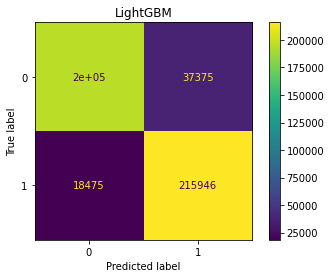

In [25]:
# LightGBM
lgb.fit(X_train, y_train)
plot_confusion_matrix(lgb, X_val, y_val)  
plt.title('LightGBM')

plt.show()

In [26]:
# 시간이 너무 많이 걸림.
# Support Vector Machine
'''
splitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)
scores = cross_validate(sv, X_train, y_train, return_train_score = True, cv=splitter)

print("train Acc.", np.mean(scores['train_score']))
print("test Acc.", np.mean(scores['test_score']))
'''

'\nsplitter = StratifiedKFold(n_splits = 3, shuffle = True, random_state=42)\nscores = cross_validate(sv, X_train, y_train, return_train_score = True, cv=splitter)\n\nprint("train Acc.", np.mean(scores[\'train_score\']))\nprint("test Acc.", np.mean(scores[\'test_score\']))\n'

In [27]:
# Support Vector Machine
'''
sv.fit(X_train, y_train)
y_pred = sv.predict(X_val)
print("Acc. :", accuracy_score(y_val, y_pred))
print("Prec. :", precision_score(y_val, y_pred))
print('Recall :', recall_score(y_val, y_pred))
print('f1. :', f1_score(y_val, y_pred))
'''

'\nsv.fit(X_train, y_train)\ny_pred = sv.predict(X_val)\nprint("Acc. :", accuracy_score(y_val, y_pred))\nprint("Prec. :", precision_score(y_val, y_pred))\nprint(\'Recall :\', recall_score(y_val, y_pred))\nprint(\'f1. :\', f1_score(y_val, y_pred))\n'

# Submission

In [28]:
submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12218 entries, 0 to 12217
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype
---  ------    --------------  -----
 0   sequence  12218 non-null  int64
 1   state     12218 non-null  int64
dtypes: int64(2)
memory usage: 191.0 KB


In [29]:
lgb_test= lgb.predict(test)
pred = pd.DataFrame({"sequence":test['sequence'],
              "state":lgb_test.tolist()})

In [30]:
pred['duplicated'] = pred.duplicated()
pred = pred[pred['duplicated']==False].iloc[:,:-1]

In [31]:
dd = pred['sequence'].value_counts() == 2
dd = dd[dd==True].index.to_list()

In [32]:
'''
for i in dd:
    if pred['sequence'] == i:
        print(pred[i].item)
'''

"\nfor i in dd:\n    if pred['sequence'] == i:\n        print(pred[i].item)\n"

In [33]:
submission.to_csv('submission.csv', index=True)